## Import required packages

### This exercise will teach you how to iteratively exclude a set of exclusion features, creating overlapping exclusions that could represent a realistic regional land eligibility assessment.
### Herein, we present ONE possible approach to organize your inout files, you are free to apply your own data structures later.

In [1]:
import glaes as gl
import geokit as gk
import pathlib
import os
import datetime

## Define filepaths and folders

In [2]:
# NOTE: The results folder exists in your repo under /student_files/results/, but the files created therein will not be pushed back to git

# this is the current working directory ("student_files/exercises")
cwd = pathlib.Path().cwd()
print(f"Current working directory: {cwd}")

# the results folder is in "student_files/results", so go "2 folders up"
results_folder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'results')
# make sure folder exists
assert os.path.isdir(results_folder), f"results folder does not exist: '{results_folder}'"

print(f"Results folder:", results_folder)

Current working directory: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources
Results folder: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results


In [3]:
# just like before, we determine our datafolder, here in a one liner
data_basefolder = os.path.join(pathlib.Path().cwd().parent.parent, 'data')
print(data_basefolder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data


In [4]:
region_shp="region_shapefiles//COUNTRY_gadm_shapes_GID_level_1.shp"
# NOTE: If you replace 'level_1' by 'level_0', the shp will contain the country shape (not the region)
# In that case, you must also define the region as 'NER' below and the 'where' parameter in the gk.vector.extractFeatures() must refer to the GID_0 attribute instead of GID_1

## Define input params

In [5]:
region='NER.5_1' # if you changed the path to level_0 above, change to 'NER' or other alpha-3 country code here
resolution=100

In [6]:
# again, the country are the first 3 letters of the region code
country=region[:3]
country

'NER'

In [7]:
# from the global country shapefile, extract only the row for the selected country
region_df = gk.vector.extractFeatures(os.path.join(data_basefolder, region_shp.replace('COUNTRY', country)), where=f"GID_1='{region}'") # GID_1 must be changed to GID_0 here if level_0 is applied
region_df

,geom,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,"POLYGON ((2.23391604 13.53053188,2.22839999 13...",NER,Niger,NER.5_1,Niamey,None,None,Communauté Urbaine,Capital District,None,NE.NI


## Create an ec object for our study region

<Axes: >

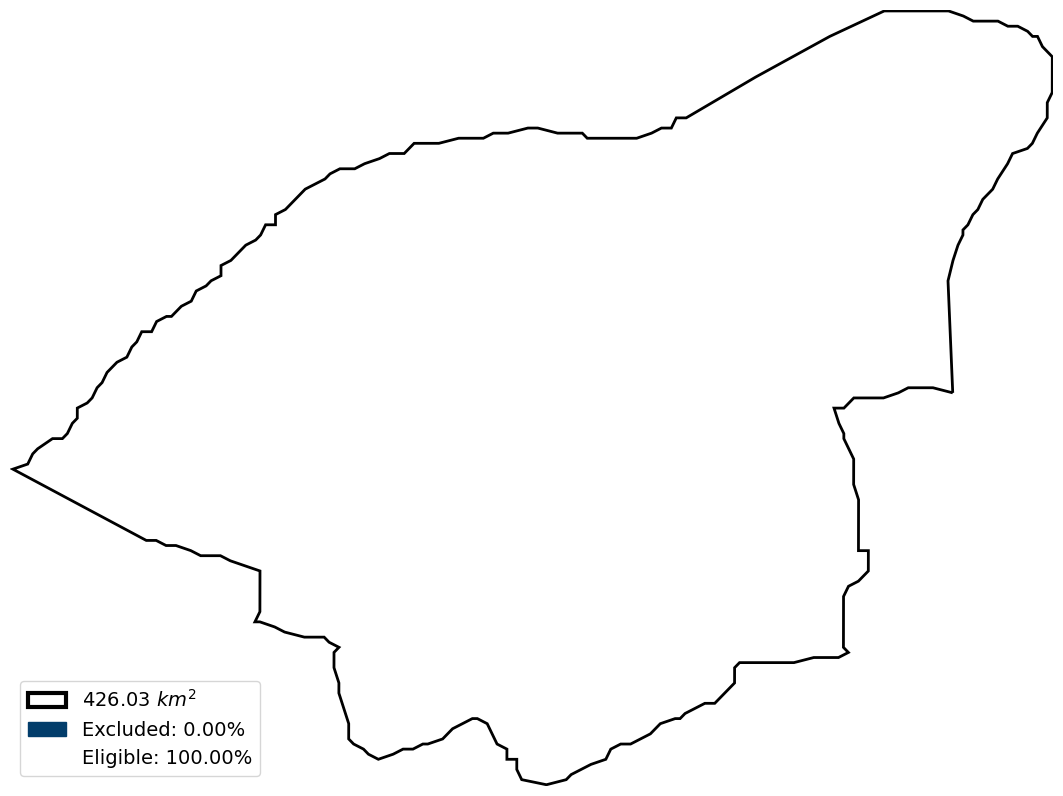

In [8]:
# now create an empty ExclusionCalculator class instance for our region, with the srs that we created above, and save as variable ec
ec = gl.ExclusionCalculator(
    region=os.path.join(data_basefolder, region_shp.replace('COUNTRY', country)), # you can load directly from a shapefile
    where=f"GID_1='{region}'", # if you only want certain features from that shapefile (here only our study region shape), you must define that by a where string, just like in the earlier sub task
    srs=gk.srs.EPSG3857, # again, we use EPSG:3857 as an LAEA for our study region
    pixelRes=resolution,
)
# show the ec shape and state of eligibility
ec.draw()

<Axes: >

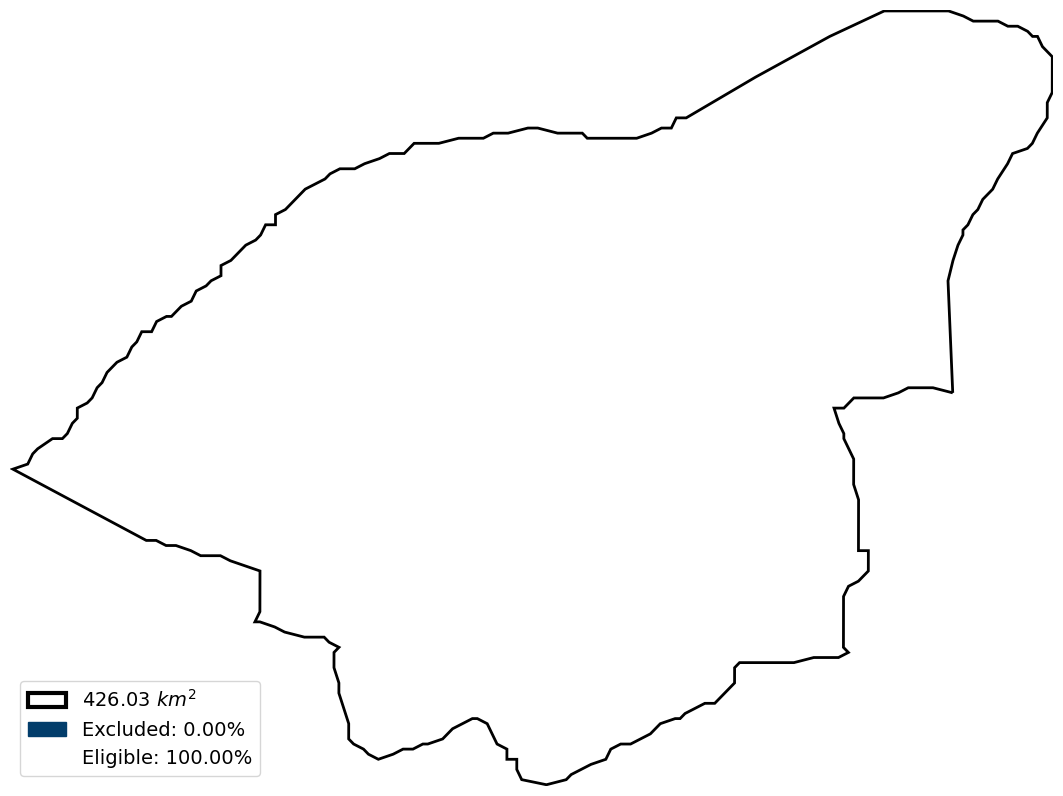

In [9]:
# we will now create a COPY of this ec object so we can apply placement distribution repeatedly to the same fresh ec object

from copy import copy # usually you would import this at the beginning, only to show how it works here
ec_clean = copy(ec)

# draw ec_clean, you see, it is the same ec object
ec_clean.draw()

## Define LEA exclusions

In [10]:
# for this example, we define our exclusion cases in a dictionary
# we can then exclude them below, based on a particular and unique dict key
# the filepath is always the relative path within the data folder, so the path elements can later be combined

exclusions_dict={
    'small airports':{
        'exclusion_filepath':'exclusion_datasets//OurAirports//COUNTRY//COUNTRY_ourairports.shp',
        'buffer':2000,
        'where':"type in ('small_airport', 'airfield')",
        },
    
    'medium/large airports':{
        'exclusion_filepath':'exclusion_datasets//OurAirports//COUNTRY//COUNTRY_ourairports.shp',
        'buffer':5000,
        'where':"type in ('medium_airport', 'large_airport')",
        },
    
    'primary roads':{
        'exclusion_filepath':'exclusion_datasets//OSM//COUNTRY//COUNTRY_gis_osm_roads_free_1.shp',
        'buffer':200,
        'where':"fclass in ('trunk', 'primary', 'primary_link', 'trunk_link', 'motorway')",
        },
    
    'secondary roads':{
        'exclusion_filepath':'exclusion_datasets//OSM//COUNTRY//COUNTRY_gis_osm_roads_free_1.shp',
        'buffer':100,
        'where':"fclass in ('secondary', 'secondary_link')",
        },

    'railways':{
        'exclusion_filepath':'exclusion_datasets//OSM//COUNTRY//COUNTRY_gis_osm_railways_free_1.shp',
        'buffer':200,
        'where':"fclass IN ('rail','light_rail','monorail','narrow_gauge','miniature','rack')",
        },

    'powerlines':{
        'exclusion_filepath':'exclusion_datasets//OSM//COUNTRY//COUNTRY_osm_powerlines.shp',
        'buffer':200,
        'where':None,
        },

    'nature protected areas (polygons)':{
        'exclusion_filepath':'exclusion_datasets//WDPA//COUNTRY//COUNTRY_extract_WDPA_areas.shp',
        'buffer':1000,
        'where':"IUCN_cat in ('Ia', 'Ib', 'II', 'III', 'IV')",
        },

    'nature protected areas (points)':{
        'exclusion_filepath':'exclusion_datasets//WDPA//COUNTRY//COUNTRY_extract_WDPA_points.shp',
        'buffer':1000,
        'where':"IUCN_cat in ('Ia', 'Ib', 'II', 'III', 'IV')",
        },

    'important bird areas (IBA)':{
        'exclusion_filepath':'exclusion_datasets//IBA//COUNTRY//COUNTRY_extract_ImportantBirdAreas.shp',
        'buffer':1000,
        'where':None,
        },
        
    'human settlements':{
        'exclusion_filepath': f'exclusion_datasets//WSF2019//COUNTRY//{region}_extract_WSF2019_clipped.tif',
        'buffer':500,
        'value':255, 
        'resampleAlg':'max',
        #NOTE: When we have a raster file (see .tif extension here above), we need a 'value' argument (not 'where') and a 'resampleAlg' argument 
    },
    # NOTE: Human settlements tend to have very many distributed features and usually needs buffers, which makes it a complex and slow exclusion! 
    # This can easily exceed the memory ability of your computer, especially when analyzing large study areas.
    # If so you would need to preprocess the raster file to a coarser resolution; then use the 'max' resample algorithm (see the next exercise task for details)

    # If you are facing issues NOW, please skip this exclusion now by simply commenting out the 'human settlements' key and the 3 lines below. 
    # The exercise also works without this settlement exclusion!
    
    'forests':{
        'exclusion_filepath':r'exclusion_datasets//CGLS//COUNTRY//COUNTRY_warped_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif', #NOTE: sometime you get SyntaxErrors for malformed characters related to backslashes \, this can be resolved by formatting as raw (r) string: r""
        'buffer':100,
        'value':"[111-116],[121-126]", #NOTE: This describes a range of 111 to 116 AND 121 to 126, both INCLUDING the endpoints 
        'resampleAlg':'near', 
        # NOTE: the resampleAlg 'near' means that the geographically nearest input cell value will be applied. 
        # This is a good choice for categorical rasters when input dataset resolution is the same or greater than your analysis resolution
    }
}

## Exclude single exclusion cases

Memory useage during calc: 171.4453125 MB


<Axes: >

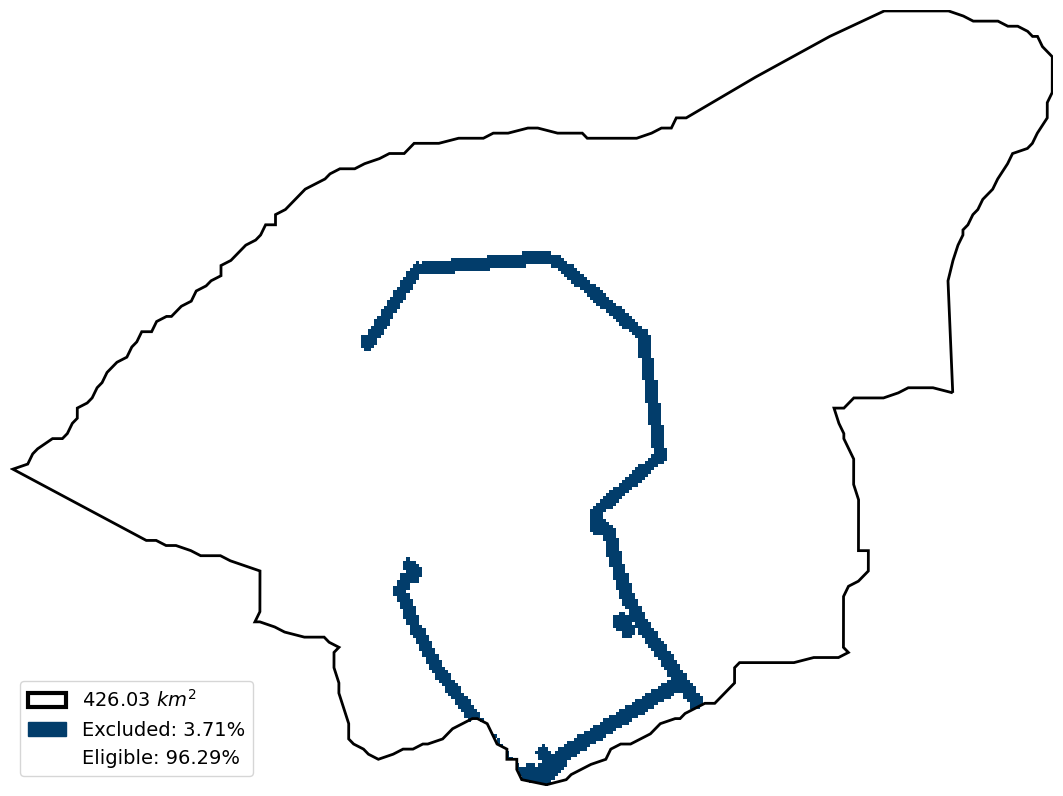

In [11]:
# we can now exclude exemplary exclusion cases

# as a first exclusion, we choose bird areas
# it must be spelled EXACTLY like the key in the above exclusions_dict
exclusion="powerlines"

ec.excludeVectorType(
    source = os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace('COUNTRY', country)),
    where = exclusions_dict[exclusion]['where'],
    buffer = exclusions_dict[exclusion]['buffer'],
)
# we see the buffered powerlines in our region and the exclusion percentags
ec.draw()

In [12]:
# keep in mind: we only wish to exclude a SINGLE exclusion case here, but powerlines were excluded before already
# so we must first reset the ec object to have an empty instance (without exclusions) again!
# This works by overwriting the ec variable with a copy of our "clean" backup copy ec_clean that we created before the first exclusion
ec = copy(ec_clean)
# note that 100% are eligible again, so no exclusion applied yet
ec.percentAvailable

100.0

Memory useage during calc: 170.36328125 MB


<Axes: >

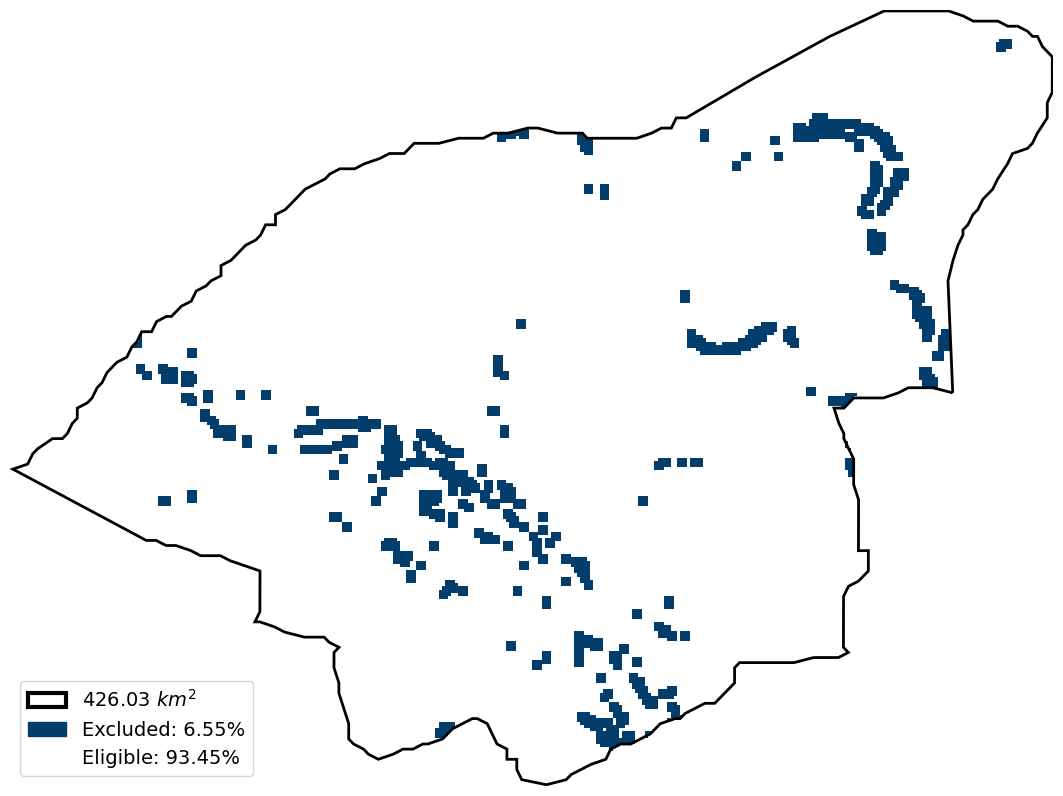

In [13]:
# now try to exclude another one, let us choose forests here
exclusion="forests"

# exclude the exclusion dataset from the clean ec object - NOTE that we are using excludeRasterType() this time since we have a raster file!
ec.excludeRasterType(
    source = os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace('COUNTRY', country)),
    value = exclusions_dict[exclusion]['value'],
    buffer = exclusions_dict[exclusion]['buffer'],
    resampleAlg = exclusions_dict[exclusion]['resampleAlg'],
)

ec.draw()
# As expected, there is not so much forest in our study region

## Apply overlapping exclusions

In [14]:
# Until now, we have excluded single exclusions only
# the current ec object contains the exclusion of the forests above as we can see from the remaining eligible percentage:
ec.percentAvailable

93.44881815834566

Memory useage during calc: 178.98828125 MB


<Axes: >

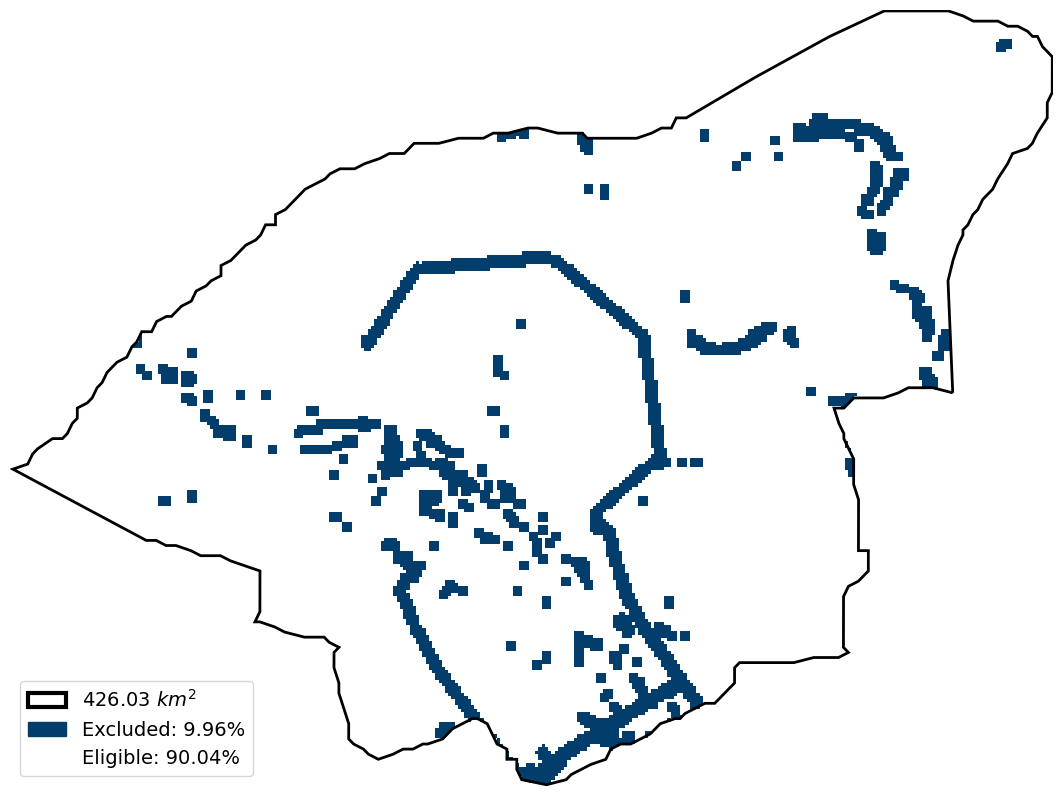

In [15]:
# we exclude the powerlines again, this time WITHOUT clearing the ec object before so the excluded areas are added to the existing exclusions:
exclusion="powerlines"

ec.excludeVectorType(
    source = os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace('COUNTRY', country)),
    where = exclusions_dict[exclusion]['where'],
    buffer = exclusions_dict[exclusion]['buffer'],
)

ec.draw()

# looking at the result, you can see how the two exclusions now overlap!
# you can also see how the eligibility went down again.

## Iteratively apply multiple exclusions

In [16]:
# for the coming application, we first reset the ec object ONCE
ec = copy(ec_clean)

2025-03-21 10:21:08.522951 Now excluding: small airports
Memory useage during calc: 174.015625 MB
2025-03-21 10:21:08.615175 Now excluding: medium/large airports
Memory useage during calc: 182.66796875 MB
2025-03-21 10:21:08.729258 Now excluding: primary roads
Memory useage during calc: 196.87890625 MB
2025-03-21 10:21:13.700547 Now excluding: secondary roads
Memory useage during calc: 199.6484375 MB
2025-03-21 10:21:18.637952 Now excluding: railways
Memory useage during calc: 199.5546875 MB
2025-03-21 10:21:18.750919 Now excluding: powerlines
Memory useage during calc: 199.5 MB
2025-03-21 10:21:18.873286 Now excluding: nature protected areas (polygons)
2025-03-21 10:21:18.881910 Now excluding: nature protected areas (points)
2025-03-21 10:21:18.885850 Now excluding: important bird areas (IBA)
2025-03-21 10:21:18.889279 Now excluding: human settlements
Memory useage during calc: 199.6171875 MB
2025-03-21 10:21:20.274213 Now excluding: forests
Memory useage during calc: 193.62890625 MB


<Axes: >

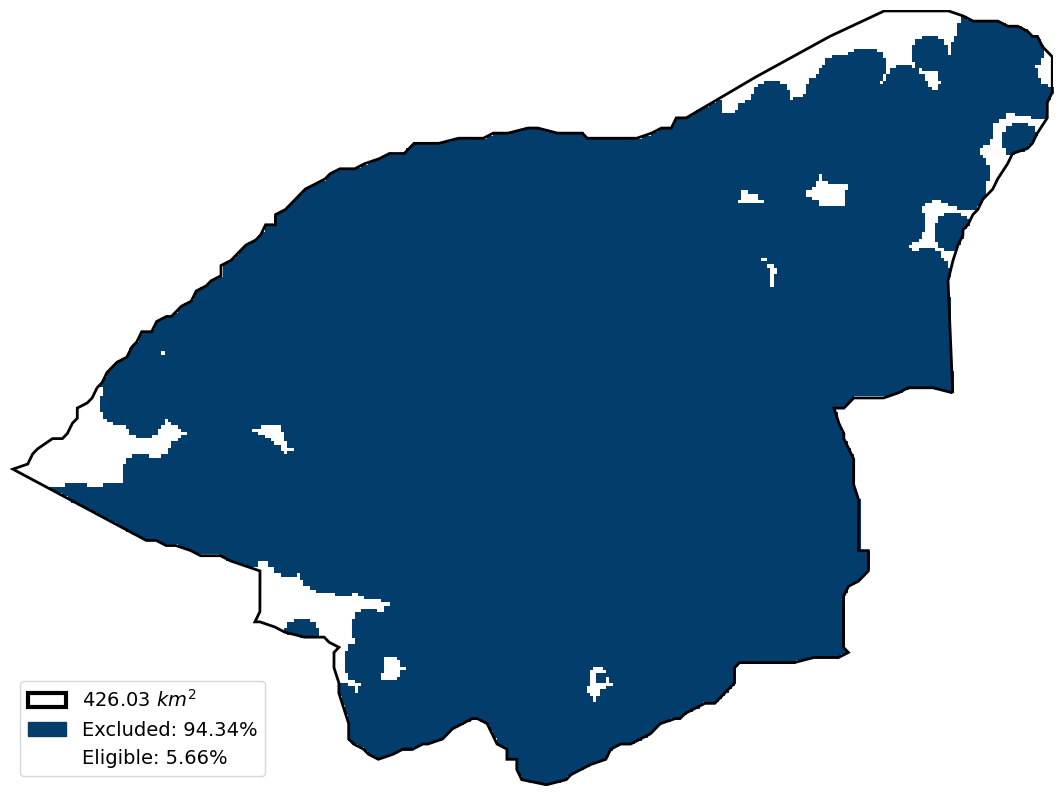

In [17]:
# using the predefined exclusion cases from our dictionary before, we can now iterate over ALL exclusion cases and exclude them to overlap exclusions (without refreshing the ec object again)
# this is done with a 'for' loop, iterating over the dictionary keys:

for exclusion in exclusions_dict.keys():
    print(datetime.datetime.now(), "Now excluding:", exclusion)
    filepath = os.path.join(
        data_basefolder,
        exclusions_dict[exclusion]['exclusion_filepath'].replace('COUNTRY', country),
    ) 
    # extract the file extension
    extension = filepath.split('.')[-1]
    # based on filetype extension, decide how to process the dataset
    # first check if we have a vector file at hand
    if extension in ['shp']:
        assert 'where' in exclusions_dict[exclusion].keys(), f"If the exclusion file is a vector file, a 'where' parameter must be given in the exclusion_dict, even if it can have the value None."
        ec.excludeVectorType(
            source = filepath,
            where = exclusions_dict[exclusion]['where'],
            buffer = exclusions_dict[exclusion]['buffer'],
        )
    # else it should be a raster input file
    elif extension in ['tif', 'tiff', 'geotiff']:
        assert 'value' in exclusions_dict[exclusion].keys() and 'resampleAlg' in exclusions_dict[exclusion].keys(), f"If the exclusion file is a raster file, a 'value' and 'resampleAlg' parameter must be given in the exclusion_dict, even if it can have the value None."
        ec.excludeRasterType(
            source = filepath,
            value = exclusions_dict[exclusion]['value'],
            buffer = exclusions_dict[exclusion]['buffer'],
            resampleAlg = exclusions_dict[exclusion]['resampleAlg'],
        )
    else:
        # if the extension is neither in the vector nor raster type list, raise an error
        raise OSError(f"Dataset has an unknown extension: .{extension}")

# now show the resulting, overlapping exclusions
ec.draw()

# TASK: Add the exclusion of water surfaces to the ec object above

#### Hint #1: Water surfaces are contained in the Copernicus Global Land Service (CGLS) landcover dataset which is already in your data folder.
#### Hint #2: QGIS can help you to ensure that you are using the correct classes